In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [46]:
df_train = pd.read_csv("../data/train.csv")  # 학습용 데이터
df_test = pd.read_csv("../data/submission.csv")  # 테스트 데이터(제출파일의 데이터)


In [47]:
df_train.head()  # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


### 데이터 전처리 및 t-SNE 압축

In [48]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [49]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]


for col in label_columns:
    df_train[col] = label_encoding(df_train[col])

In [50]:
# 상관계수가 NaN인 id_strategic_ver, it_strategic_ver, idit_strategic_ver을 제거
col_to_drop = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']
df_train = df_train.drop(col_to_drop, axis=1)

df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,7546,0,0.066667,32160,10,0,NaN,418,62,...,33,246,1,0,0.003079,0.026846,0,28,0,True
1,1.0,6887,0,0.066667,23122,10,0,12.0,301,96,...,33,246,1,0,0.003079,0.026846,0,0,1,True
2,1.0,5037,0,0.088889,1755,10,0,144.0,160,56,...,21,246,1,0,0.003079,0.026846,0,17,2,True
3,1.0,1943,0,0.088889,4919,10,0,NaN,166,44,...,21,246,1,0,0.003079,0.026846,0,44,3,True
4,1.0,4307,0,0.088889,17126,29,0,NaN,84,97,...,21,246,0,0,0.003079,0.026846,0,86,4,True


In [51]:
# 결측치 개수 확인
df_train.isnull().sum()

bant_submit                    0
customer_country               0
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type                  0
enterprise                     0
historical_existing_cnt    45543
customer_job                   0
lead_desc_length               0
inquiry_type                   0
product_category               0
product_subcategory            0
product_modelname              0
customer_country.1             0
customer_position              0
response_corporate             0
expected_timeline              0
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area                  0
business_subarea               0
lead_owner                     0
is_converted                   0
dtype: int64

In [52]:
# 결측치가 있는 행을 제거할 경우 1696개로 축소됨
df_train_filtered = df_train.dropna()
df_train_filtered.isnull()
# is_converted 열을 기준으로 TRUE와 FALSE로 나누기
df_true = df_train_filtered[df_train_filtered['is_converted'] == True]
df_false = df_train_filtered[df_train_filtered['is_converted'] == False]
print(f'True 개수: {df_true.shape[0]}')
print(f'False 개수: {df_false.shape[0]}')

True 개수: 157
False 개수: 1539


### 3차원 압축 및 시각화

In [65]:
perplexity = 70
tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, n_iter=300)
tsne_result = tsne.fit_transform(df_train_filtered)

In [66]:
# 'is_converted' 값에 따라 데이터를 분할
tsne_result_true = tsne_result[df_train_filtered['is_converted'] == True]
tsne_result_false = tsne_result[df_train_filtered['is_converted'] == False]

print(f'True 개수: {tsne_result_true.shape[0]}')
print(f'False 개수: {tsne_result_false.shape[0]}')


True 개수: 157
False 개수: 1539


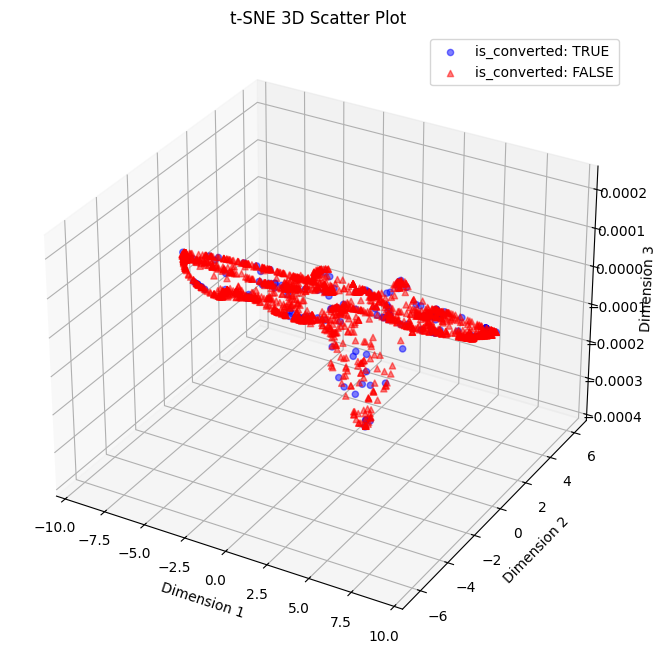

In [67]:
# 3차원 산점도 그리기
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# TRUE 데이터 산점도 그리기
ax.scatter(tsne_result_true[:, 0], tsne_result_true[:, 1], tsne_result_true[:, 2], 
           label='is_converted: TRUE', c='blue', marker='o', alpha=0.5)

# FALSE 데이터 산점도 그리기
ax.scatter(tsne_result_false[:, 0], tsne_result_false[:, 1], tsne_result_false[:, 2], 
           label='is_converted: FALSE', c='red', marker='^', alpha=0.5)
# 그래프 설정
ax.set_title("t-SNE 3D Scatter Plot")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()

# 그래프 출력
plt.show()

### 2차원 압축 및 시각화

In [76]:
from sklearn.preprocessing import MinMaxScaler

perplexity = 50
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=300)
tsne_result = tsne.fit_transform(df_train_filtered)

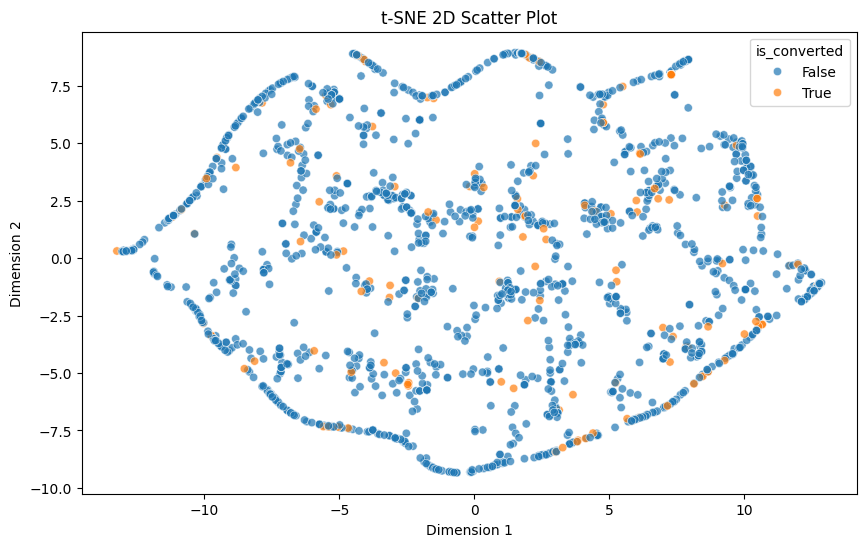

In [77]:
# DataFrame 생성 (is_converted 추가)
df_tsne_2d = pd.DataFrame(data=tsne_result, columns=['Dimension 1', 'Dimension 2'])
df_tsne_2d['is_converted'] = df_train_filtered['is_converted'].values

# 2차원 산점도 그리기
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='is_converted', data=df_tsne_2d, alpha=0.7)
plt.title('t-SNE 2D Scatter Plot')
plt.show()

In [78]:
# 'is_converted' 값에 따라 데이터를 분할
tsne_result_true = tsne_result[df_train_filtered['is_converted'] == True]
tsne_result_false = tsne_result[df_train_filtered['is_converted'] == False]

print(f'True 개수: {tsne_result_true.shape[0]}')
print(f'False 개수: {tsne_result_false.shape[0]}')


True 개수: 157
False 개수: 1539


In [79]:
# 3차원 산점도 그리기
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='2d')

# TRUE 데이터 산점도 그리기
ax.scatter(tsne_result_true[:, 0], tsne_result_true[:, 1], 
           label='is_converted: TRUE', c='blue', marker='o', alpha=0.5)

# FALSE 데이터 산점도 그리기
ax.scatter(tsne_result_false[:, 0], tsne_result_false[:, 1],
           label='is_converted: FALSE', c='red', marker='^', alpha=0.5)
# 그래프 설정
ax.set_title("t-SNE 3D Scatter Plot")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()

# 그래프 출력
plt.show()

ValueError: Unknown projection '2d'

<Figure size 1200x800 with 0 Axes>

### 결과에 대한 원인 분석

- 결측치가 존재하는 행을 제거하는 방식으로 진행하였기에
- 